In [1]:
import argparse
import time
import msgpack
from enum import Enum, auto

import numpy as np
import csv

from planning_utils import a_star, heuristic, create_grid
from udacidrone import Drone
from udacidrone.connection import MavlinkConnection
from udacidrone.messaging import MsgID
from udacidrone.frame_utils import global_to_local, local_to_global

from route_planner import RoutePlanner

import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

In [2]:
TARGET_ALTITUDE = 50
SAFETY_DISTANCE = 5 # 0 # 5
ROUTE_GRAPH_NUM_SAMPLES = 3000 # 300 # 3000
ROUTE_GRAPH_K = 30 # 10 # 30


In [3]:
class States(Enum):
    MANUAL = auto()
    ARMING = auto()
    TAKEOFF = auto()
    WAYPOINT = auto()
    LANDING = auto()
    DISARMING = auto()
    PLANNING = auto()


In [4]:
class GlobalLocation():
    def __init__(self, lon=0.0, lat=0.0, alt=0.0):
        self._lon = float(lon)
        self._lat = float(lat)
        self._alt = float(alt)
    
    @property
    def location(self):
        return (self._lon, self._lat, self._alt)
    
    @property
    def lat(self):
        return self._lat
    
    @property
    def lon(self):
        return self._lon
    
    @property
    def alt(self):
        return self._alt
        
    def get_location(self):
        return (self._lon, self._lat, self._alt)
    
    def set_location(self, lon, lat, alt):
        self._lon = lon
        self._lat = lat
        self._alt = alt

def get_start_and_goal_locations():
    # lon/lat min/max:  -122.40251813469173 -122.39200186357762 37.78966453206827 37.79790277484265
    # center lon/lat -122.39745 37.79248

    loc_1 = GlobalLocation(-122.397450, 37.792480, 2.0)
    loc_2 = GlobalLocation(-122.401399, 37.797423, 2.0)
#     loc_2 = GlobalLocation(-122.397475, 37.792779, 2.0)  # close by open position
    
    start_loc = loc_1
    goal_loc = loc_2

#     start_loc = loc_2
#     goal_loc = loc_1

    return (start_loc, goal_loc)

def get_goal_location():
    loc = GlobalLocation(-122.401399, 37.797423, 2.0)
    return loc.location

In [5]:
class MotionPlanning(Drone):

    def __init__(self, connection=None, threaded=False, target_altitude=TARGET_ALTITUDE, 
                 safety_distance=SAFETY_DISTANCE, graph_num_samples=ROUTE_GRAPH_NUM_SAMPLES, 
                 graph_k=ROUTE_GRAPH_K, use_grid=False, prune_path=True):
        
#         super().__init__(connection)
        
        # after connection init (super().__init__) the graph building runs very slow
        # so even before we init the connection, first initialize the route planner

        self._threaded = threaded
        self._target_altitude = target_altitude
        self._use_grid = use_grid
        self._prune_path = prune_path
        
        # for MavLink (or any other) connection
        self._connection = connection
        self._connection_initialized = False
        
        self._in_mission = False
        self._end_mission = False
        
        # get the map center lon/lat
        map_center_lon = 0.0
        map_center_lat = 0.0
        with open('colliders.csv', 'r') as f:
            csv_reader = csv.reader(f);
            first_line = next(csv_reader)
            map_center_lon = float(first_line[1].split()[1])
            map_center_lat = float(first_line[0].split()[1])
        
        # Read in obstacle map
        self._data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)
        
        # find the min and max longitude and latitude
        # here x in north (latitude) and y is east (longitude)
        # x (north) here should be y (up) in Cartesian-Coords and 
        # y (east) here is y (right) in Cartesian-Coords.  
        x_north_min = np.min(self._data[:, 0] - self._data[:, 3])
        x_north_max = np.max(self._data[:, 0] + self._data[:, 3])
        y_east_min = np.min(self._data[:, 1] - self._data[:, 4])
        y_east_max = np.max(self._data[:, 1] + self._data[:, 4])
        
        # the bottom-left corner and top-right corner will give is the min and max lon-lat values.
        # local_to_global(...) takes in NED sequence and returns lon-lat-alt sequence
        min_lla = local_to_global([x_north_min, y_east_min, 0.0], [map_center_lon, map_center_lat, 0.0])
        max_lla = local_to_global([x_north_max, y_east_max, 0.0], [map_center_lon, map_center_lat, 0.0])
        
        self._longitude_min, self._latitude_min, _ = min_lla
        self._longitude_max, self._latitude_max, _ = max_lla

        
        if not self._use_grid:
            self._route_planner = RoutePlanner(target_altitude = self._target_altitude,
                                               safety_distance=safety_distance,
                                               graph_num_samples=graph_num_samples,
                                               graph_k=graph_k)

        self.target_position = np.array([0.0, 0.0, 0.0])
        self.waypoints = []
        self.check_state = {}
        
        # global home, start, and goal locations in (lon/lat/alt)
        self.global_home_loc = GlobalLocation(map_center_lon, map_center_lat, 0.0)
        self.global_start_loc = None
        self.global_goal_loc = None
        
        print("Global Home (lat/lon/alt): ", self.global_home_loc.location)

        # initial state
        self.flight_state = States.MANUAL
        
    def __del__(self):
        self.stop()
        self._end_mission = True
        self.end_mission()

    def fly(self, global_goal):
        
#         if len(global_goal) == 3 and (global_start is None or len(global_start) == 3):
        if self.is_valid_location(global_goal):
            # set the goal location (start location is always current position)
            self.global_goal_loc = GlobalLocation(global_goal[0], global_goal[1], global_goal[2])
            # start the mission
            self.start_mission()
        else:
            print("Cannot fly! Invalid goal location...")
    
    # fly to a lat/lon position on the map
    def fly_to(self, lat, lon, alt=0.0):
        global_goal = (lon, lat, alt)
        if self.is_valid_location(global_goal):
            # set the goal location (start location is always current position)
            self.global_goal_loc = GlobalLocation(global_goal[0], global_goal[1], global_goal[2])
            # start the mission
            self.start_mission()
        else:
            print("Cannot fly! Invalid goal location...")

    def start_mission(self):
        
        print("Starting Mission...")

        if self._in_mission is False:

            # start logging
            self.start_log("Logs", "NavLog.txt")

            print("Initializing the connection...")
            if self._connection is None:
                # initiate a connection with 60 sec timeout
                self._connection = MavlinkConnection('tcp:127.0.0.1:5760', threaded=self._threaded, timeout=3000)
            
            super().__init__(self._connection)
            print("... Done!")

            # register all your callbacks here
            self.register_callback(MsgID.LOCAL_POSITION, self.local_position_callback)
            self.register_callback(MsgID.LOCAL_VELOCITY, self.velocity_callback)
            self.register_callback(MsgID.STATE, self.state_callback)

            self._in_mission = True
            
            print("Starting connection... ")
            self.start()
            print("... Done!")
            if self._threaded:
                print("Blocking in start_mission...")
                while self._end_mission is False:
                    pass
                print("start_mission unblocked...")
            
            self.end_mission()

        else:
            print("ERROR: Drone already in mission...")
            

    def end_mission(self):
        if self._end_mission is True:
            # stop logging
            self.stop_log()
            self._in_mission = False
            
    def is_valid_location(self, location):
        is_valid = True
        
        try:
            assert (len(location) == 3), "Invalid Location. Must be [longitude, latitude, altitude]"
            assert (self._longitude_min <= location[0] <= self._longitude_max), "Invalid Longitude"
            assert (self._latitude_min <= location[1] <= self._latitude_max), "Invalid Latitude"
            assert (location[2] == 0.0), "Invalid Altitude. Altitude Must Be 0 (Ground Level)"
        except AssertionError as msg:
            print(msg)
            is_valid = False
                
        return is_valid
                
    def local_position_callback(self):
        if self.flight_state == States.TAKEOFF:
            if -1.0 * self.local_position[2] > 0.95 * self.target_position[2]:
                self.waypoint_transition()
        elif self.flight_state == States.WAYPOINT:
            target_alt = self.target_position[3]
            # check whether we are close to target position (N-E-Alt)
            # local_position[2] (depth) is negative altitude, keep altitude proximity to 0.5 meters
            if (np.linalg.norm(self.target_position[0:2] - self.local_position[0:2]) < 1.0 and 
                abs(self.target_position[2] + self.local_position[2]) < 0.5):
                if len(self.waypoints) > 0:
                    self.waypoint_transition()
                else:
                    if np.linalg.norm(self.local_velocity[0:2]) < 1.0:
                        self.landing_transition()

    def velocity_callback(self):
        if self.flight_state == States.LANDING:
            if self.global_position[2] - self.global_home[2] < 0.1:
                if abs(self.local_position[2]) < 0.01:
                    self.disarming_transition()

    def state_callback(self):
        if self._in_mission:
            if self.flight_state == States.MANUAL:
                self.arming_transition()
            elif self.flight_state == States.ARMING:
                if self.armed:
                    self.plan_path()
            elif self.flight_state == States.PLANNING:
                self.takeoff_transition()
            elif self.flight_state == States.DISARMING:
                if ~self.armed & ~self.guided:
                    self.manual_transition()

    def arming_transition(self):
        self.flight_state = States.ARMING
        print("arming transition")
        self.arm()
        self.take_control()

    def takeoff_transition(self):
        self.flight_state = States.TAKEOFF
        print("takeoff transition")
        print("takeoff position: ", self.target_position)
        self.takeoff(self.target_position[2])

    def waypoint_transition(self):
        self.flight_state = States.WAYPOINT
        print("waypoint transition")
        if len(self.waypoints):
            self.target_position = self.waypoints.pop(0)
            print('target position', self.target_position)
            self.cmd_position(self.target_position[0], self.target_position[1], self.target_position[2], self.target_position[3])

    def landing_transition(self):
        self.flight_state = States.LANDING
        print("landing transition")
        self.land()

    def disarming_transition(self):
        self.flight_state = States.DISARMING
        print("disarm transition")
        self.disarm()
        self.release_control()

    def manual_transition(self):
        self.flight_state = States.MANUAL
        print("manual transition")
        self.stop()
        self._end_mission = True
        

    def send_waypoints(self):
        print("Sending waypoints to simulator ...")
        data = msgpack.dumps(self.waypoints)
        self.connection._master.write(data)

    def plan_path(self):
        self.flight_state = States.PLANNING
        TAKEOFF_ALTITUDE = self._target_altitude  # 2 # 5
#         SAFETY_DISTANCE = 5

        self.target_position[2] = TAKEOFF_ALTITUDE

        # TODO: read lat0, lon0 from colliders into floating point values
        # Done in __init__

        # TODO: set home position to (lon0, lat0, 0)
        self.set_home_position(self.global_home_loc.lon, 
                               self.global_home_loc.lat, 
                               self.global_home_loc.alt)
        time.sleep(1)

        # TODO: retrieve current global position
        global_position = self.global_position
 
        # TODO: convert to current local position using global_to_local()
        local_position = global_to_local(global_position, self.global_home)
        
        print('self.global_home {0}, self.global_position {1}, self.local_position {2}, calculated local_position {3}'.format(self.global_home, self.global_position,
                                                                         self.local_position, local_position))

        if self._use_grid:
            # Read in obstacle map
#             data = np.loadtxt('colliders.csv', delimiter=',', dtype='Float64', skiprows=2)

            # Define a grid for a particular altitude and safety margin around obstacles
            grid, north_offset, east_offset = create_grid(self._data, TAKEOFF_ALTITUDE, SAFETY_DISTANCE)
            print("North offset = {0}, east offset = {1}".format(north_offset, east_offset))

            # Define starting point on the grid (this is just grid center)
    #         grid_start = (-north_offset, -east_offset)
            # TODO: convert start position to current position rather than map center
            start_n = int(local_position[0]-north_offset)
            start_e = int(local_position[1]-east_offset)

            grid_start = (start_n, start_e)

            # Set goal as some arbitrary position on the grid
            local_goal = global_to_local(self.global_goal_loc.location, 
                                         self.global_home)

            goal_n = int(local_goal[0]-north_offset)
            goal_e = int(local_goal[1]-east_offset)
            grid_goal = (goal_n, goal_e)
            # TODO: adapt to set goal as latitude / longitude position and convert

            # Run A* to find a path from start to goal
            # TODO: add diagonal motions with a cost of sqrt(2) to your A* implementation
            # or move to a different search space such as a graph (not done here)
            print('Local Start and Goal: ', grid_start, grid_goal)
            print("Searching for a path ...")
            path, _ = a_star(grid, heuristic, grid_start, grid_goal)

            # TODO: prune path to minimize number of waypoints
            # TODO (if you're feeling ambitious): Try a different approach altogether!

            # Convert path to waypoints
            waypoints = [[p[0] + north_offset, p[1] + east_offset, TAKEOFF_ALTITUDE, 0] for p in path]
#             print("Waypoints: {0}".format(waypoints))
        else: 
            #
            # build a graph of free space
            #
        
            # get start and goal locations. start locations is always current location
            self.global_start_loc = GlobalLocation(self.global_position[0], 
                                                   self.global_position[1], 
                                                   self.global_position[2])

            local_start = global_to_local(self.global_start_loc.location, self.global_home)
            local_goal = global_to_local(self.global_goal_loc.location, self.global_home)

            print("global start:", self.global_start_loc.location, 
                  " global goal:", self.global_goal_loc.location, " local_start: ", local_start, 
                  " local_goal: ", local_goal)

            print("Searching for a path ...")
            waypoints = self._route_planner.get_flight_waypoints(local_start, local_goal, 
                                                                 prune_path=self._prune_path)

            print("Final Waypoints: {0}".format(waypoints))


        print("Num waypoints: ", len(waypoints))
        
        if len(waypoints):
            # Set self.waypoints
            self.waypoints = waypoints
            
            # TODO: send waypoints to sim
            self.send_waypoints()
        else:
            print("No Path found!")

    def get_ned_waypoint(self, global_loc):
        return [int(i) for i in global_to_local(global_loc, self.global_home)]

#     def start(self):
#         self.start_log("Logs", "NavLog.txt")

#         print("starting connection")
#         self.connection.start()

#         # Only required if they do threaded
#         # while self.in_mission:
#         #    pass

#         self.stop_log()


In [6]:
# def fly_drone(global_goal):
#     drone = MotionPlanning(connection=None, target_altitude=TARGET_ALTITUDE, safety_distance=SAFETY_DISTANCE,
#                            graph_num_samples=ROUTE_GRAPH_NUM_SAMPLES, graph_k=ROUTE_GRAPH_K, use_grid=False,
#                            prune_path=True, threaded=False)

#     drone.fly(global_goal)
#     time.sleep(1)
#     del drone
    
def fly_drone(lat, lon, alt=0):
    drone = MotionPlanning(connection=None, target_altitude=TARGET_ALTITUDE, safety_distance=SAFETY_DISTANCE,
                           graph_num_samples=ROUTE_GRAPH_NUM_SAMPLES, graph_k=ROUTE_GRAPH_K, use_grid=False,
                           prune_path=True, threaded=False)

    drone.fly_to(lat, lon, alt)
    time.sleep(1)
    del drone

In [7]:
# close by open position (-122.397475, 37.792779, 2.0)
fly_drone(37.792779, -122.397475)

Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)
Starting Mission...
Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
self.global_home [-122.39745   37.79248    0.     ], self.global_position [-122.3974499   37.7924808    0.226    ], self.local_position [ 0.09497554  0.00592119 -0.22693402], calculated local_position [ 0.0888165  0.0082325 -0.226    ]
global start: (-122.3974499, 37.7924808, 0.226)  global goal: (-122.397475, 37.792779, 0.0)  local_start:  [ 0.0888165  0.0082325 -0.226    ]  local_goal:  [33.15977549 -2.41492512 -0.        ]
Searching for a path ...
Route Planner - Found Path (1 Waypoints): [(-9.46937539278025, 8.812954217094614, 50.0)]
All Un-Pruned Waypoints: [[0, 0, 50, 0], [-9, 9, 50, 0], [33, -2, 50, 0], [33, -2, 0, 0]]
Pruning Waypoints...
[0, 0, 50]  -  [0, 0, 50]
Can Connect
[0, 0, 50]  -  [

In [7]:
drone = MotionPlanning(connection=None, target_altitude=TARGET_ALTITUDE, safety_distance=SAFETY_DISTANCE,
                       graph_num_samples=ROUTE_GRAPH_NUM_SAMPLES, graph_k=ROUTE_GRAPH_K, use_grid=False,
                       prune_path=True, threaded=False)

Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)


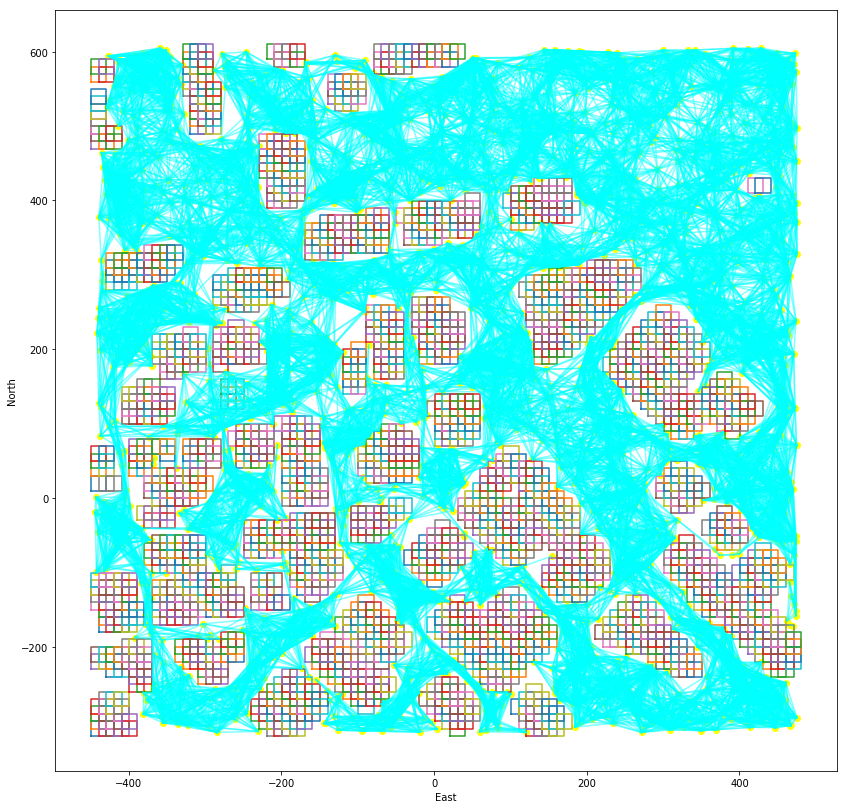

In [8]:
drone._route_planner.plot_route_graph()

In [9]:
# north west
fly_drone(37.797423, -122.401399)

Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)
Starting Mission...
Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3928623   37.7952614   -0.045    ], self.local_position [309.00289917 408.08398438   0.04333574], calculated local_position [311.16624711 402.2126465    0.045     ]
global start: (-122.3928623, 37.7952614, -0.045)  global goal: (-122.401399, 37.797423, 0.0)  local_start:  [311.16624711 402.2126465    0.045     ]  local_goal:  [ 546.14853892 -350.91185147   -0.        ]
Searching for a path ...
Route Planner - Found Path (16 Waypoints): [(316.72189580476623, 397.4847531170383, 50.0), (330.8188614628006, 349.90017801691886, 50.0), (340.3984106861107, 300.1445366530352, 50.0), (335.05140977622483, 236.50466620547172, 5

In [8]:
# east position
fly_drone(37.795245, -122.392800, 0.0)
# fly_drone(37.795245, -122.392800)

Closing connection ...
Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)
Starting Mission...
Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3974757   37.7927771   -0.015    ], self.local_position [32.96347427 -1.99364865  0.01548091], calculated local_position [32.9060665  -2.18436232  0.015     ]
global start: (-122.3974757, 37.7927771, -0.015)  global goal: (-122.3928, 37.795245, 0.0)  local_start:  [32.9060665  -2.18436232  0.015     ]  local_goal:  [309.38229375 407.70948737  -0.        ]
Searching for a path ...
Route Planner - Found Path (9 Waypoints): [(37.84242197263586, -7.68733315025554, 50.0), (59.94315061824301, 28.777305154420617, 50.0), (75.78090118434545, 81.93704144589822, 50.0), (114.53900803244738, 124.9629038729

In [12]:
# south east #1
fly_drone(37.789705, -122.393040, 2.0)

Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
Closing connection ...
Closing connection ...
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)
Starting Mission...
Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3926387   37.7900864    0.064    ], self.local_position [-265.99838257  427.95648193   -0.06707006], calculated local_position [-262.87072484  425.62878869   -0.064     ]
global start: (-122.3926387, 37.7900864, 0.064)  global goal: (-122.39304, 37.789705, 0.0)  local_start:  [-262.87072484  425.62878869   -0.064     ]  local_goal:  [-305.41637891  390.56972755   -0.        ]
Searching for a path ...
Route Planner - Found Path (1 Waypoints): [(-266.0048788029782, 428.1742450968734, 50.0)]
All Un-Pruned Waypoints: [[-263, 426, 50, 0], [-266, 428, 50, 0], [-305, 391, 50, 0

In [11]:
# south east #2
fly_drone(37.790311, -122.392185, 2.0)

Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)
Starting Mission...
Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3930537   37.7897374    0.1      ], self.local_position [-304.78442383  391.06201172   -0.09430674], calculated local_position [-301.82944002  389.34012536   -0.1       ]
global start: (-122.3930537, 37.7897374, 0.1)  global goal: (-122.392185, 37.790311, 0.0)  local_start:  [-301.82944002  389.34012536   -0.1       ]  local_goal:  [-237.69183438  465.41428277   -0.        ]
Searching for a path ...
Warning! Input Map Location (NED) Not In Free Space
Warning! Goal location not in Free (Open) Space
Using Closest Graph Node As Destination
Route Planner - Found Path (2 Waypoints): [(-296.6001337965903, 388.445531009163

In [8]:
# south east #1
fly_drone((-122.393040, 37.789705, 2.0))

Closing connection ...
Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)
Starting Mission...
Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.4014022   37.7973925    0.216    ], self.local_position [ 545.78552246 -351.01028442   -0.21404487], calculated local_position [ 542.76276693 -351.17190962   -0.216     ]
global start: (-122.4014022, 37.7973925, 0.216)  global goal: (-122.39304, 37.789705, 2.0)  local_start:  [ 542.76276693 -351.17190962   -0.216     ]  local_goal:  [-305.41637891  390.56972755   -2.        ]
Searching for a path ...
Route Planner - Found Path (21 Waypoints): [(543.3508740623793, -353.7816248913259, 50.0), (496.0066994543553, -336.8177072882977, 50.0), (458.2261348187564, -293.393435169536, 50.0), (419.8677591

In [11]:
# south east #2
fly_drone((-122.392185, 37.790311, 2.0))

Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)
Starting Mission...
Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3930549   37.7897368    0.212    ], self.local_position [-305.02038574  390.96588135   -0.19837062], calculated local_position [-301.89669569  389.23489911   -0.212     ]
global start: (-122.3930549, 37.7897368, 0.212)  global goal: (-122.392185, 37.790311, 2.0)  local_start:  [-301.89669569  389.23489911   -0.212     ]  local_goal:  [-237.69183438  465.41428277   -2.        ]
Searching for a path ...
Warning! Input Map Location (NED) Not In Free Space
Warning! Goal location not in Free (Open) Space
Using Closest Graph Node As Destination
Route Planner - Found Path (2 Waypoints): [(-296.6001337965903, 388.4455310091

In [12]:
# close by open position (-122.397475, 37.792779, 2.0)
fly_drone((-122.397475, 37.792779, 0.0))

Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)
Starting Mission...
Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3926387   37.7900854    0.16     ], self.local_position [-266.12759399  427.95681763   -0.15714706], calculated local_position [-262.98167452  425.62950941   -0.16      ]
global start: (-122.3926387, 37.7900854, 0.16)  global goal: (-122.397475, 37.792779, 0.0)  local_start:  [-262.98167452  425.62950941   -0.16      ]  local_goal:  [33.11726813 -2.12408934 -0.        ]
Searching for a path ...
Route Planner - Found Path (11 Waypoints): [(-266.0048788029782, 428.1742450968734, 50.0), (-227.0731537202862, 404.1051504075359, 50.0), (-187.34627664624463, 345.8919780404915, 50.0), (-139.03803902915155, 295.6750856951332

### Individual calls

In [6]:
# TARGET_ALTITUDE = 50
# SAFETY_DISTANCE = 0
# ROUTE_GRAPH_NUM_SAMPLES = 3000
# ROUTE_GRAPH_K = 30

drone = MotionPlanning(connection=None, target_altitude=TARGET_ALTITUDE, safety_distance=SAFETY_DISTANCE, 
                 graph_num_samples=ROUTE_GRAPH_NUM_SAMPLES, graph_k=ROUTE_GRAPH_K, use_grid=False)

Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)


In [9]:
# drone.connection_init()

Initializing the connection...
Logs/TLog.txt
... Done!


In [11]:
# drone.stop()

Closing connection ...


In [7]:
# drone.start()

In [15]:
# global_to_local((-122.392228, 37.790335, 0.0),(-122.39745, 37.79248, 0.0))

array([-235.01114602,  461.32007492,   -0.        ])

In [7]:
# close by open position (-122.397475, 37.792779, 2.0)
drone.fly((-122.397475, 37.792779, 0.0))

Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
Searching for a path ...
self.global_home [-122.39745   37.79248    0.     ], self.global_position [-122.3974492   37.7924792    0.059    ], self.local_position [-0.0866064   0.06330448 -0.05961677], local_position [-0.08830581  0.07100834 -0.059     ]
global start: (-122.3974492, 37.7924792, 0.059)
global goal: (-122.397475, 37.792779, 0.0)
local_position:  [-0.08830581  0.07100834 -0.059     ]
local local_start:  [-0.08830581  0.07100834 -0.059     ]
local local_goal:  [33.15977549 -2.41492512 -0.        ]
[1580, 1745, 1857, 1856, 1581]
closest_node_indices:  [1184 1191 1177 1186 1174]
[-0.08830581  0.07100834 -0.059     ] (-9.46937539278025, 8.812954217094614, 50.0) True
[1606, 1607, 1581, 1582, 1608]
closest_node_indices:  [1180 1173 1185 1189 1187]
[33.15977549 -2.41492512 -0.        ] (37.84242197263586, -7.68733315025554, 50.0) True
Route Planner: start_ned:  [-0.0883

In [14]:
del drone

In [16]:
del drone.connection

In [16]:
loc = (-122.395884, 37.793248, 0.)      
global_to_local(loc, drone.global_home_loc.location)

array([ 86.09913538, 137.3284874 ,  -0.        ])

In [10]:
# drone.stop()
# drone._flight_initialized = False

Closing connection ...


In [11]:
drone.connection._master.

In [10]:
# north west
drone.fly((-122.401399, 37.797423, 0.0))

Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3974749   37.7927706    0.14     ], self.local_position [32.23900223 -1.92479181 -0.14050905], local_position [32.18534735 -2.10927866 -0.14      ]
global start: (-122.3974749, 37.7927706, 0.14)
global goal: (-122.401399, 37.797423, 0.0)
local_position:  [32.18534735 -2.10927866 -0.14      ]
local local_start:  [32.18534735 -2.10927866 -0.14      ]
local local_goal:  [ 546.14853892 -350.91185147   -0.        ]
[1606, 1607, 1581, 1582, 1608]
closest_node_indices:  [1180 1173 1185 1189 1187]
[32.18534735 -2.10927866 -0.14      ] (37.84242197263586, -7.68733315025554, 50.0) True
[351, 350, 352, 349, 310]
closest_node_indices:  [191 199 194 200 211]
[ 546.14853892 -350.91185147   -0.        ] (543.3508740623793, -353.7816248913259, 50.0) True
Route Planner: start_ned:  

In [11]:
drone.connected

False

In [10]:
drone.fly((-122.3974499, 37.7924799, 2.0))

Connection already established...
Flight initialization done...
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3930587   37.7897392   -0.012    ], self.local_position [-304.58239746  390.65921021    0.00452404], local_position [-301.63258839  388.8985857     0.012     ]
global start: (-122.3930587, 37.7897392, -0.012)
global goal: (-122.3974499, 37.7924799, 2.0)
local_position:  [-301.63258839  388.8985857     0.012     ]
local local_start:  [-301.63258839  388.8985857     0.012     ]
local local_goal:  [-0.05354558  0.29971182 -2.        ]
[603, 685, 686, 604, 644]
closest_node_indices:  [812 818 801 820 821]
[-301.63258839  388.8985857     0.012     ] (-303.9594438895658, 385.081017750982, 50.0) True
[1580, 1745, 1857, 1856, 1581]
closest_node_indices:  [683 680   3 687 681]
[-0.05354558  0.29971182 -2.        ] (11.35436754051085, -4.536506639620882, 50.0) True
Route Planner: start_ned:  [-301.63258839

In [ ]:
# east position
drone.fly((-122.392800, 37.795245, 0.0))
# lon: -122.392185
# lat: 37.790311

In [ ]:
# south east #1
drone.fly((-122.393040, 37.789705, 2.0))
# lon: -122.393040
# lat: 37.789705


Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
... Done!
Flight initialization done...
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.4013987   37.7973915    0.128    ], self.local_position [ 545.67034912 -350.69039917   -0.1232317 ], local_position [ 542.65379024 -350.8630608    -0.128     ]
global start: (-122.4013987, 37.7973915, 0.128)
global goal: (-122.39304, 37.789705, 2.0)
local_position:  [ 542.65379024 -350.8630608    -0.128     ]
local local_start:  [ 542.65379024 -350.8630608    -0.128     ]
local local_goal:  [-305.41637891  390.56972755   -2.        ]
[350, 351, 349, 352, 309]
closest_node_indices:  [191 199 200 194 206]
[ 542.65379024 -350.8630608    -0.128     ] (543.3508740623793, -353.7816248913259, 50.0) True
[2801, 2770, 3143, 2802, 3110]
closest_node_indices:  [1349 1344  115 1343 1342]
[-305.41637891  390.56972755   -2.        ] (-296.6

In [9]:
# south east #2
drone.fly((-122.392185, 37.790311, 2.0))
# lon: -122.392185
# lat: 37.790311


Logs/NavLog.txt
Initializing the connection...
Logs/TLog.txt
... Done!
Starting connection... 
... Done!
Flight initialization done...
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3927998   37.7952456    0.121    ], self.local_position [307.24194336 413.628479    -0.12423614], local_position [309.44897798 407.72666343  -0.121     ]
global start: (-122.3927998, 37.7952456, 0.121)
global goal: (-122.392185, 37.790311, 2.0)
local_position:  [309.44897798 407.72666343  -0.121     ]
local local_start:  [309.44897798 407.72666343  -0.121     ]
local local_goal:  [-237.69183438  465.41428277   -2.        ]
[3783, 2934, 3766, 3796, 3810]
closest_node_indices:  [1827 1828  465 1818  454]
[309.44897798 407.72666343  -0.121     ] (316.72189580476623, 397.4847531170383, 50.0) True
[3180, 3143, 3181, 3217, 3144]
Warning! Input Map Location (NED) Not In Free Space
Warning! Goal location not in Free (Open) Space
Using

In [16]:
drone.fly((-122.3974499, 37.7924799, 2.0))

Connection already established...
Flight initialization done...
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3922283   37.7903365    0.097    ], self.local_position [-238.31910706  464.44418335   -0.10205911], local_position [-234.88740055  461.5834145    -0.097     ]
global start: (-122.3922283, 37.7903365, 0.097)
global goal: (-122.3974499, 37.7924799, 2.0)
local_position:  [-234.88740055  461.5834145    -0.097     ]
local local_start:  [-234.88740055  461.5834145    -0.097     ]
local local_goal:  [-0.05354558  0.29971182 -2.        ]
[3180, 3143, 3181, 3217, 3144]
Warning! Input Map Location (NED) Not In Free Space
Error! Start location not in Free (Open) Space OR Un-Connectable to Route Graph
Please Change Start Location!
Waypoints: []
Waypoints: []
Num waypoints:  0
No Path found!
takeoff transition
waypoint transition
landing transition
disarm transition
manual transition


In [14]:
drone.fly((-122.397475, 37.792779, 2.0))

Connection already established...
Flight initialization done...
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3922262   37.7903355    0.082    ], self.local_position [-238.33003235  464.5682373    -0.08260509], local_position [-234.99714833  461.7690364    -0.082     ]
global start: (-122.3922262, 37.7903355, 0.082)
global goal: (-122.397475, 37.792779, 2.0)
local_position:  [-234.99714833  461.7690364    -0.082     ]
local local_start:  [-234.99714833  461.7690364    -0.082     ]
local local_goal:  [33.11726813 -2.12408934 -2.        ]
[3180, 3143, 3181, 3217, 3144]
Warning! Input Map Location (NED) Not In Free Space
Error! Start location not in Free (Open) Space OR Un-Connectable to Route Graph
Please Change Start Location!
Waypoints: []
Waypoints: []
Num waypoints:  0
No Path found!
takeoff transition
waypoint transition
landing transition
disarm transition
manual transition


In [14]:
drone.fly((-122.397475, 37.792779, 2.0))

Connection already established...
Flight initialization done...
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3979859   37.793604     0.144    ], self.local_position [124.84372711 -47.34986115  -0.14661814], local_position [124.36101191 -47.69569119  -0.144     ]
global start: (-122.3979859, 37.793604, 0.144)
global goal: (-122.397475, 37.792779, 2.0)
local_position:  [124.36101191 -47.69569119  -0.144     ]
local local_start:  [124.36101191 -47.69569119  -0.144     ]
local local_goal:  [33.11726813 -2.12408934 -2.        ]
node_indices:  [[126 120]]
node_indices:  [[360 362]]
start_node:  (139.2126496060045, -37.37669619615144, 1.6771307510848725)
Route Planner: start and goal nodes:  (139.2126496060045, -37.37669619615144, 1.6771307510848725) (23.970885939267646, 17.660823835233145, 4.563169644474673)
Path cost:  127.74240456762685
Path:  [(139.2126496060045, -37.37669619615144, 1.6771307510848725)]
wa

In [13]:
drone.fly((-122.397475, 37.792779, 2.0))

Connection already established...
Flight initialization done...
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.4010821   37.7959268    0.139    ], self.local_position [ 382.92709351 -322.56542969   -0.14119941], local_position [ 380.3242048  -321.94863059   -0.139     ]
global start: (-122.4010821, 37.7959268, 0.139)
global goal: (-122.397475, 37.792779, 2.0)
local_position:  [ 380.3242048  -321.94863059   -0.139     ]
local local_start:  [ 380.3242048  -321.94863059   -0.139     ]
local local_goal:  [33.11726813 -2.12408934 -2.        ]
node_indices:  [[593 589]]
node_indices:  [[360 362]]
start_node:  (373.9213471383421, -318.62968291146854, 0.798298831741106)
Route Planner: start and goal nodes:  (373.9213471383421, -318.62968291146854, 0.798298831741106) (23.970885939267646, 17.660823835233145, 4.563169644474673)
Path cost:  1641.4075084610324
Path:  [(373.9213471383421, -318.62968291146854, 0.7982988

In [12]:
drone.fly((-122.401399, 37.797423, 2.0))

Connection already established...
Flight initialization done...
arming transition
Searching for a path ...
self.global_home [-122.3974533   37.7924804    0.       ], self.global_position [-122.3978893   37.7938286    0.024    ], self.local_position [149.80059814 -38.75006866  -0.0249803 ], local_position [149.33508933 -39.35112293  -0.024     ]
global start: (-122.3978893, 37.7938286, 0.024)
global goal: (-122.401399, 37.797423, 2.0)
local_position:  [149.33508933 -39.35112293  -0.024     ]
local local_start:  [149.33508933 -39.35112293  -0.024     ]
local local_goal:  [ 546.14853892 -350.91185147   -2.        ]
node_indices:  [[119 121]]
node_indices:  [[803 802]]
start_node:  (145.0577887114997, -42.23407485520704, 1.329969337050405)
Route Planner: start and goal nodes:  (145.0577887114997, -42.23407485520704, 1.329969337050405) (535.7788538814755, -354.4898612508689, 3.946489952627296)
Path cost:  1771.557688356271
Path:  [(145.0577887114997, -42.23407485520704, 1.329969337050405), 

### Obstacle Tree test

In [33]:
print(global_to_local((-122.393160, 37.789690, 0.0), (-122.3974533, 37.7924804, 0.0)))
print(global_to_local((-122.393040, 37.789705, 0.0), (-122.3974533, 37.7924804, 0.0)))
print(global_to_local((-122.392185, 37.790311, 0.0), (-122.3974533, 37.7924804, 0.0)))
print(global_to_local((-122.397530, 37.789821, 0.0), (-122.3974533, 37.7924804, 0.0)))


[-307.14920578  380.01468564   -0.        ]
[-305.41637891  390.56972755   -0.        ]
[-237.69183438  465.41428277   -0.        ]
[-295.10308338   -4.85179787   -0.        ]


In [7]:
drone._route_planner._obstacles_tree.get_arrays()

(array([[-310.2389, -439.2315],
        [-300.2389, -439.2315],
        [-290.2389, -439.2315],
        ...,
        [ 257.8061,  425.1645],
        [ 293.9967,  368.3391],
        [ 281.5162,  354.4156]]),
 array([   0,    1,    2, ..., 2938, 2970, 3073]),
 array([(   0, 3845, 0, 18144.62512742), (   0, 1922, 0, 11482.70972319),
        (1922, 3845, 0, 19684.23861875), (   0,  961, 0,  3826.82941241),
        ( 961, 1922, 0,  4219.88797883), (1922, 2883, 0,  5610.81112125),
        (2883, 3845, 0,  4262.11721844), (   0,  480, 0,  3241.62744086),
        ( 480,  961, 0,  4755.86965171), ( 961, 1441, 0,  3964.96257443),
        (1441, 1922, 0,  5027.46500781), (1922, 2402, 0,  2071.15909577),
        (2402, 2883, 0,  2057.10050665), (2883, 3364, 0,  3762.64512983),
        (3364, 3845, 0,  4353.6480517 ), (   0,  240, 0,   894.0497749 ),
        ( 240,  480, 0,  1388.66816883), ( 480,  720, 0,  1512.10118709),
        ( 720,  961, 0,  1339.99047385), ( 961, 1201, 0,   913.75598936),
  

In [8]:
s = (-310.2389, -439.2315, -2.0)  # idx 0 in above cell
# s = (-310.23, -439.2315, -2.0)
# s = (501.10403765659856, 229.13292414568423, 0.8419639783410932)
s = (101.42231618, -19.0996931, -0.174) # local_start
g = (546.14853892, -350.91185147, -2.0)  # local_goal

# open but non connectable global lla locations
# s = (-291.10308338, -4.35179787, -1.0)

# s = (-307.14920578, 380.01468564, -0.0)
# s = (-305.41637891, 390.56972755, -0.0)
# s = (-237.69183438, 465.41428277, -0.0)
# s = (-295.10308338, -4.85179787, -1.0)

# a open north location
(-122.395955, 37.797679, 0.0)

query_loc = s

In [9]:
ot_indices = drone._route_planner._obstacles_tree.query(np.array([query_loc[0], query_loc[1]]).reshape(1, -1), k=5, return_distance=True)
ot_indices

(array([[27.0380218 , 29.57190186, 29.91431223, 31.01035126, 32.06383632]]),
 array([[1707, 1586, 1748, 1749, 1747]]))

In [10]:
drone._route_planner._is_location_in_free_space(query_loc)

[1707, 1586, 1748, 1749, 1747]


True

In [11]:
drone._route_planner._get_closest_connectable_graph_node(query_loc)

[1707, 1586, 1748, 1749, 1747]
closest_node_indices:  [125 128 124 552 115]
(101.42231618, -19.0996931, -0.174) (101.72042218030793, -19.052316530196094, 3.033082311695379) True


((101.72042218030793, -19.052316530196094, 3.033082311695379), True)

In [13]:
s_node, _ = drone._route_planner._get_closest_connectable_graph_node(s)
s, s_node                                                            

[1707, 1586, 1748, 1749, 1747]
closest_node_indices:  [125 128 124 552 115]
(101.42231618, -19.0996931, -0.174) (101.72042218030793, -19.052316530196094, 3.033082311695379) True


((101.42231618, -19.0996931, -0.174),
 (101.72042218030793, -19.052316530196094, 3.033082311695379))

In [14]:
g_node, _ = drone._route_planner._get_closest_connectable_graph_node(g)
g, g_node

[351, 350, 352, 349, 310]
closest_node_indices:  [803 802 801 504 807]
(546.14853892, -350.91185147, -2.0) (542.6298886223931, -343.84028401001285, 0.09069517386634418) True


((546.14853892, -350.91185147, -2.0),
 (542.6298886223931, -343.84028401001285, 0.09069517386634418))

In [15]:
p, _ = drone._route_planner.search_path(s_node, g_node)
p

Route Planner - search_path - start_node: (101.72042218030793, -19.052316530196094, 3.033082311695379) goal_node: (542.6298886223931, -343.84028401001285, 0.09069517386634418)


[(101.72042218030793, -19.052316530196094, 3.033082311695379),
 (128.7356684716712, -141.71027078525879, 4.153694134009752),
 (180.06702977422918, -154.22281638692226, 2.3836521705324234),
 (347.76747686195, -181.6955314163634, 4.478261308935796),
 (465.0447097120643, -271.10029199250664, 4.662742241813756),
 (518.2399269235798, -358.3099580101271, 4.996060155284304)]

In [16]:
w = [s]+p+[g]
w

[(101.42231618, -19.0996931, -0.174),
 (101.72042218030793, -19.052316530196094, 3.033082311695379),
 (128.7356684716712, -141.71027078525879, 4.153694134009752),
 (180.06702977422918, -154.22281638692226, 2.3836521705324234),
 (347.76747686195, -181.6955314163634, 4.478261308935796),
 (465.0447097120643, -271.10029199250664, 4.662742241813756),
 (518.2399269235798, -358.3099580101271, 4.996060155284304),
 (546.14853892, -350.91185147, -2.0)]

In [17]:
drone._route_planner.get_flight_waypoints(s, g)

[1707, 1586, 1748, 1749, 1747]
closest_node_indices:  [125 128 124 552 115]
(101.42231618, -19.0996931, -0.174) (101.72042218030793, -19.052316530196094, 3.033082311695379) True
[351, 350, 352, 349, 310]
closest_node_indices:  [803 802 801 504 807]
(546.14853892, -350.91185147, -2.0) (542.6298886223931, -343.84028401001285, 0.09069517386634418) True
Route Planner: start_ned:  (101.42231618, -19.0996931, -0.174)
Route Planner: graph_start_node:  (101.72042218030793, -19.052316530196094, 3.033082311695379)
Route Planner: graph_goal_node:  (542.6298886223931, -343.84028401001285, 0.09069517386634418)
Route Planner: goal_ned:  (546.14853892, -350.91185147, -2.0)
Route Planner - search_path - start_node: (101.72042218030793, -19.052316530196094, 3.033082311695379) goal_node: (542.6298886223931, -343.84028401001285, 0.09069517386634418)
Route Planner - graph_path from search:  [(101.72042218030793, -19.052316530196094, 3.033082311695379), (128.7356684716712, -141.71027078525879, 4.1536941340

[[102.0, -19.0, 4, 0],
 [102.0, -19.0, 4, 0],
 [129.0, -142.0, 5, 0],
 [180.0, -154.0, 3, 0],
 [348.0, -182.0, 5, 0],
 [465.0, -271.0, 5, 0],
 [518.0, -358.0, 5, 0],
 [546, -351, -2, 0]]

### Nearest Node Test

In [8]:
drone._route_planner._route_graph_nodes

[(0.5030725194398542, -37.13237203090432, 50.0),
 (-24.812738603721016, -44.45617755010625, 50.0),
 (-45.267147956454096, -36.04500886798786, 50.0),
 (-1.0125387781533277, 20.27774119594028, 50.0),
 (-23.504822477211917, 28.260277433052238, 50.0),
 (-14.153469358111408, 34.454720799967674, 50.0),
 (579.7562839471937, 60.686681431800935, 50.0),
 (585.8582744600419, 68.04520286244622, 50.0),
 (567.4938465162732, 61.76408170588917, 50.0),
 (575.719673347048, 43.089057519833545, 50.0),
 (562.7103077647457, 67.16300660366068, 50.0),
 (566.1318503259183, 47.553762043371194, 50.0),
 (557.8046990502619, 63.74304952185673, 50.0),
 (562.3266596806866, 79.29335059242067, 50.0),
 (555.0284193791674, 51.461286273094856, 50.0),
 (558.4760750245691, 40.71420092537926, 50.0),
 (555.4698703524195, 40.97037992538259, 50.0),
 (568.1482452755781, 91.43691779286291, 50.0),
 (545.9645817198698, 58.539404789247385, 50.0),
 (565.2487209387075, 28.721054320766314, 50.0),
 (539.8533848030434, 68.87061063274484,

In [18]:
# target position [11, -5, 50, 0]
# target position [44, -48, 50, 0]
w1 = drone._route_planner._RoutePlanner__get_nearest_neighbor_node((11, -5, 50), idx_only=True)
w2 = drone._route_planner._RoutePlanner__get_nearest_neighbor_node((44, -48, 50), idx_only=True)
w1, w2

(687, 1521)

In [19]:
drone._route_planner._route_graph_nodes[687], drone._route_planner._route_graph_nodes[1521]


((31.51062552927624, 0.5173475493268143, 50.0),
 (55.71597872298673, -60.33728584987347, 50.0))

In [32]:
drone._route_planner._obstacles_tree.get_arrays()

(array([[-439.2315, -310.2389],
        [-439.2315, -300.2389],
        [-439.2315, -290.2389],
        ...,
        [ 425.1645,  257.8061],
        [ 368.3391,  293.9967],
        [ 354.4156,  281.5162]]),
 array([   0,    1,    2, ..., 2935, 2938, 3105]),
 array([(   0, 3845, 0, 28035.16096024), (   0, 1922, 0, 19694.19140424),
        (1922, 3845, 0, 19219.20993016), (   0,  961, 0,  5115.81171037),
        ( 961, 1922, 0,  5731.86957248), (1922, 2883, 0,  6271.57322302),
        (2883, 3845, 0,  4230.1619305 ), (   0,  480, 0,  4350.35351642),
        ( 480,  961, 0,  4852.21858093), ( 961, 1441, 0,  4765.34626234),
        (1441, 1922, 0,  5018.61036543), (1922, 2402, 0,  2972.38142261),
        (2402, 2883, 0,  1534.01407916), (2883, 3364, 0,  3593.29078946),
        (3364, 3845, 0,  4203.17779074), (   0,  240, 0,  1313.83038791),
        ( 240,  480, 0,  1282.23418191), ( 480,  720, 0,  1099.89773979),
        ( 720,  961, 0,  1533.37062848), ( 961, 1201, 0,  1129.08196337),
  

In [25]:
list(drone._route_planner._obstacles_tree.query([[11, -5]], k=3)[1][0])

[1857, 1856, 1745]

In [29]:
p = drone._route_planner._polygons[int(1857)]
p.center, p._height

((40.76846, -10.238860000000003), 88.0)

In [16]:
wp_start = drone._route_planner.get_closest_connectable_graph_node((101.42231618, -19.0996931, -0.174))
wp_start

closest_node_indices:  [[125 128 124 552 115]]
(101.42231618, -19.0996931, -0.174) (101.72042218030793, -19.052316530196094, 3.033082311695379) True


(101.72042218030793, -19.052316530196094, 3.033082311695379)

In [17]:
wp_goal = drone._route_planner.get_closest_connectable_graph_node((546.14853892, -350.91185147, -2.0))
wp_goal

closest_node_indices:  [[803 802 801 504 807]]
(546.14853892, -350.91185147, -2.0) (542.6298886223931, -343.84028401001285, 0.09069517386634418) True


(542.6298886223931, -343.84028401001285, 0.09069517386634418)

In [19]:
wp_path, _ = drone._route_planner.search_path((101.72042218030793, -19.052316530196094, 3.033082311695379), (542.6298886223931, -343.84028401001285, 0.09069517386634418))
wp_path

[(101.72042218030793, -19.052316530196094, 3.033082311695379),
 (128.7356684716712, -141.71027078525879, 4.153694134009752),
 (180.06702977422918, -154.22281638692226, 2.3836521705324234),
 (347.76747686195, -181.6955314163634, 4.478261308935796),
 (465.0447097120643, -271.10029199250664, 4.662742241813756),
 (518.2399269235798, -358.3099580101271, 4.996060155284304)]

In [21]:
[wp_start] + wp_path + [wp_goal]

[(101.72042218030793, -19.052316530196094, 3.033082311695379),
 (101.72042218030793, -19.052316530196094, 3.033082311695379),
 (128.7356684716712, -141.71027078525879, 4.153694134009752),
 (180.06702977422918, -154.22281638692226, 2.3836521705324234),
 (347.76747686195, -181.6955314163634, 4.478261308935796),
 (465.0447097120643, -271.10029199250664, 4.662742241813756),
 (518.2399269235798, -358.3099580101271, 4.996060155284304),
 (542.6298886223931, -343.84028401001285, 0.09069517386634418)]

In [15]:
drone._route_planner.get_nearest_neighbor_node((-108.71839644396121, 51.9952517297566, 2.4187533037694537))

node_indices:  [[413 414]]


(-94.02938406051862, 45.37231312479224, 3.7631046302114957)

In [16]:
drone._route_planner._graph_nodes[413], drone._route_planner._graph_nodes[414], drone._route_planner._graph_nodes[415]

((-108.71839644396121, 51.9952517297566, 2.4187533037694537),
 (-94.02938406051862, 45.37231312479224, 3.7631046302114957),
 (-100.01777547833657, 31.078419902285702, 0.7300536338415575))

### Old

In [6]:
drone = MotionPlanning(connection=None, use_saved_graph=True, save_graph=False, use_grid=False)

Creating obstacle tree...
Loading Graph  graph/route_graph.gpickle
...Done
READ Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)


In [7]:
drone.flight_init(threaded=True)

Initializing the connection...
Logs/TLog.txt
... Done!
Flight initialization done...


In [8]:
time.sleep(1)

In [9]:
drone.connection.open

True

In [10]:
drone.start()

Logs/NavLog.txt
starting connection
arming transition
Searching for a path ...
self.global_home [-122.39745   37.79248    0.     ], self.global_position [-122.397449    37.7924812    0.071    ], self.local_position [ 0.14844458  0.06412633 -0.07047244], local_position [ 0.13370707  0.08718733 -0.071     ]
Init global start: (-122.39745, 37.79248, 2.0)
Init global goal: (-122.401399, 37.797423, 2.0)
global start: (-122.39745, 37.79248, 2.0)
global goal: (-122.401399, 37.797423, 2.0)
local_position:  [ 0.13370707  0.08718733 -0.071     ]
local local_start:  [ 0.  0. -2.]
local local_goal:  [ 546.19104628 -351.20268725   -2.        ]
node_indices:  [[536 534]]
node_indices:  [[803 802]]
start_node:  (6.217878374708334, -5.192285915153377, 0.8908786638456323)
Route Planner: start and goal nodes:  (6.217878374708334, -5.192285915153377, 0.8908786638456323) (535.7788538814755, -354.4898612508689, 3.946489952627296)
Found a path.
Path cost:  2116.9922026747463
Path:  [(6.217878374708334, -5.1

In [11]:
drone.connection.open

True

In [ ]:
drone.fly((-122.401399, 37.797423, 2.0))

Connection already established...
Flight initialization done...


In [18]:
drone.global_home, drone.global_position, drone.local_position

(array([-122.3974533,   37.7924804,    0.       ]),
 array([-122.4014745,   37.7971393,   -0.019    ]),
 array([ 517.67108154, -357.44573975,    0.02070908]))

In [34]:
gps_1 = [-122.3974495, 37.7924792, 0.169]
gps_2 = [-123.3974495, 38.7924792, 4.169]
global_home = [-122.39745, 37.79248 ,0.]


ned_1 = global_to_local(gps_1, global_home)
# ned_2 = global_to_local([-103.6137494112514, 73.0883293568636, 4.696847634982718], [-122.39745, 37.79248 ,0.])
ned_2 = global_to_local(gps_2,global_home)

# ned_1_int = [int(i) for i in ned_1]
# ned_2_int = [int(i) for i in ned_2]

print(ned_1, ned_2)
# print(ned_1_int, ned_2_int)


[-0.08847604  0.04459473 -0.169     ] [110861.58979905 -87567.46758267     -4.169     ]


In [37]:
arr = [gps_1, gps_2]
print(arr)
# result = list(map(global_to_local, arr, [global_home]))
# print(result)

[[-122.3974495, 37.7924792, 0.169], [-123.3974495, 38.7924792, 4.169]]


In [45]:
def get_ned_waypoint(l):
#     print(l, global_home)
#     return list(global_to_local(l,global_home))
    return [ int(i) for i in global_to_local(l,global_home)]
    
list(map(get_ned_waypoint, arr))

[[0, 0, 0], [110861, -87567, -4]]

In [8]:
drone._route_planner._graph_nodes

[(501.10403765659856, 229.13292414568423, 0.8419639783410932),
 (474.6405673274874, 235.5412414696799, 0.901702139083993),
 (493.400810629947, 256.13739813491065, 1.3060120897934406),
 (504.89334591599317, 269.31506877448555, 1.0507113348862624),
 (496.77811806980327, 283.0584269351359, 2.866373381174891),
 (491.8540966317357, 290.3089032845123, 2.9929442181905137),
 (476.82071228410786, 308.7833017360107, 3.703208257850849),
 (484.0346364825003, 313.0856165265898, 0.3141283590350308),
 (436.45464543492864, 374.52019522399166, 2.3985717812134837),
 (-188.2031282816035, -291.31234057525603, 1.6153072995158064),
 (-179.4825767301851, -279.39090416924654, 0.4642174686679912),
 (-173.6288025768112, -286.48747556511967, 3.541947264492026),
 (-158.33450955257513, -291.92520615559584, 3.8360711022299077),
 (-161.7293807979394, -271.5161518954103, 0.3392121819608479),
 (-170.13053497057143, -255.2816070748035, 2.9803876211487723),
 (-187.18973189353878, -333.2462160543239, 4.241776014750931),


In [12]:
# self._graph_tree.query([point], k=2, return_distance=False)
p = (501.0, 229.0, 0.1)
drone._route_planner._graph_tree.query([p], k=2, return_distance=False)

array([[   0, 1077]])

In [9]:
for (n1, n2) in drone._route_planner._graph.edges:
    print(n1, n2)

(599.6262504976805, 391.8997955628681, 3.3751506134500167) (571.0404428229547, 385.3406920173562, 3.1421691187505774)
(599.6262504976805, 391.8997955628681, 3.3751506134500167) (579.2477269584681, 414.6160022978338, 1.875486670108562)
(599.6262504976805, 391.8997955628681, 3.3751506134500167) (581.1008017084275, 416.1575881403662, 0.2957102718822907)
(599.6262504976805, 391.8997955628681, 3.3751506134500167) (585.3217039959902, 341.0878731808061, 0.5314651434963708)
(599.6262504976805, 391.8997955628681, 3.3751506134500167) (578.412549713584, 445.6410497866764, 2.063552127068953)
(599.6262504976805, 391.8997955628681, 3.3751506134500167) (582.5424602674236, 454.9414318127516, 3.881899879910511)
(599.6262504976805, 391.8997955628681, 3.3751506134500167) (540.7995514740674, 353.14933040552614, 3.830308698248508)
(599.6262504976805, 391.8997955628681, 3.3751506134500167) (547.8941015972623, 340.17035533346916, 3.96805594639439)
(599.6262504976805, 391.8997955628681, 3.3751506134500167) (5

(-260.37513500487364, 395.1778689928643, 1.9507678523383987) (-274.91908960719246, 450.9194287099607, 2.021305704122957)
(-260.37513500487364, 395.1778689928643, 1.9507678523383987) (-314.65279179114685, 436.04386639703614, 3.836346061221629)
(-260.37513500487364, 395.1778689928643, 1.9507678523383987) (-288.5156337190615, 457.3431676421287, 4.666730737427187)
(-260.37513500487364, 395.1778689928643, 1.9507678523383987) (-259.41848844632267, 469.5501934827539, 4.541807511239011)
(-260.37513500487364, 395.1778689928643, 1.9507678523383987) (-262.3527856071685, 315.0802107527063, 4.283882622335355)
(-260.37513500487364, 395.1778689928643, 1.9507678523383987) (-289.29384707421247, 308.2437959638546, 4.819386379398603)
(-260.37513500487364, 395.1778689928643, 1.9507678523383987) (-171.69450960093445, 345.3649030151556, 4.804923501826082)
(-260.37513500487364, 395.1778689928643, 1.9507678523383987) (-302.66550223780473, 300.6924824711025, 0.4436478171219177)
(-260.37513500487364, 395.177868

In [10]:
drone._longitude_min, drone._longitude_max, drone._latitude_min, drone._latitude_max

(-122.40251813469173,
 -122.39200186357762,
 37.78966453206827,
 37.79790277484265)

In [12]:
round((drone._longitude_min + drone._longitude_max)/2, 6), round((drone._latitude_min + drone._latitude_max)/2, 6)

(-122.39726, 37.793784)

In [15]:
drone.global_home_loc.location

(-122.39745, 37.79248, 0.0)

In [14]:
# 0: (-310.2389, 599.7611) # x  -> NORTH
# 1: (-439.2315, 470.7685) # y  -> EAST
# 2: (1.5, 106.0) # z  -> ALTITUDE (positive up, note the difference with NED coords)

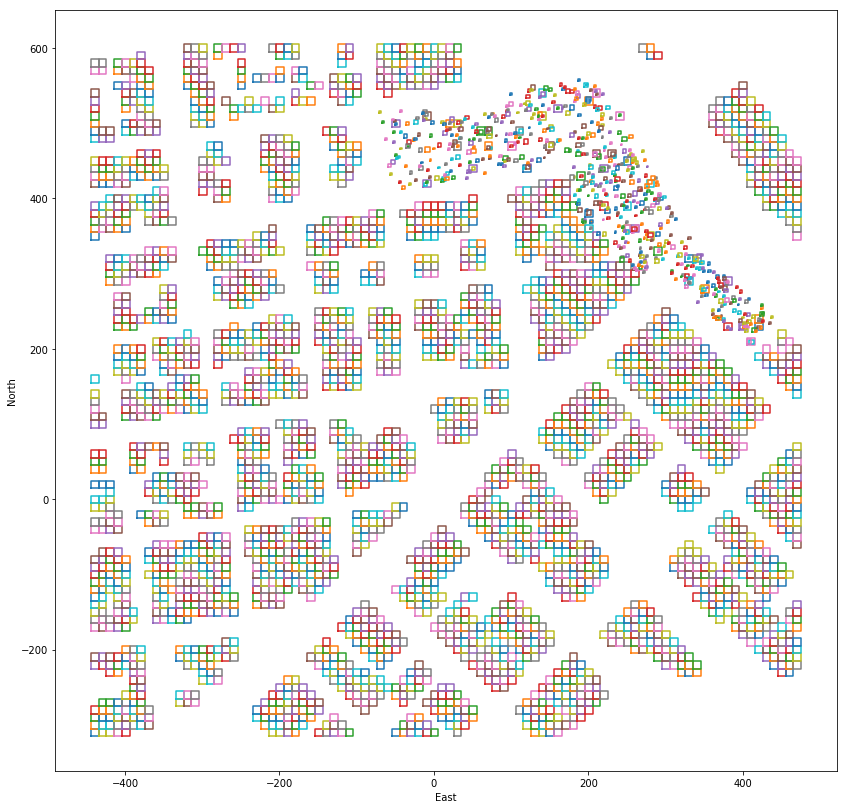

In [8]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# plt.rcParams['figure.figsize'] = 14, 14

# # visualize the graph!
# fig = plt.figure()
# # plt.imshow(grid, cmap='Greys', origin='lower')
# # nmin = np.min(data[:, 0])
# # emin = np.min(data[:, 1])

# # plot the polygons
# for poly1 in drone._route_planner._polygons:
#     plt.plot(*poly1._polygon.exterior.xy)

# plt.xlabel('East')
# plt.ylabel('North')
# # plt.gca().invert_xaxis()
# # plt.gca().invert_yaxis()


# plt.show()

In [28]:
p = drone._route_planner._polygons[0]
p._polygon.exterior.xy

(array('d', [-320.2389, -320.2389, -300.2389, -300.2389, -320.2389]),
 array('d', [-449.2315, -429.2315, -429.2315, -449.2315, -449.2315]))

In [26]:
x, y = p._polygon.exterior.xy
print(list(x)), print(list(y))

[-320.2389, -320.2389, -300.2389, -300.2389, -320.2389]
[-449.2315, -429.2315, -429.2315, -449.2315, -449.2315]


(None, None)

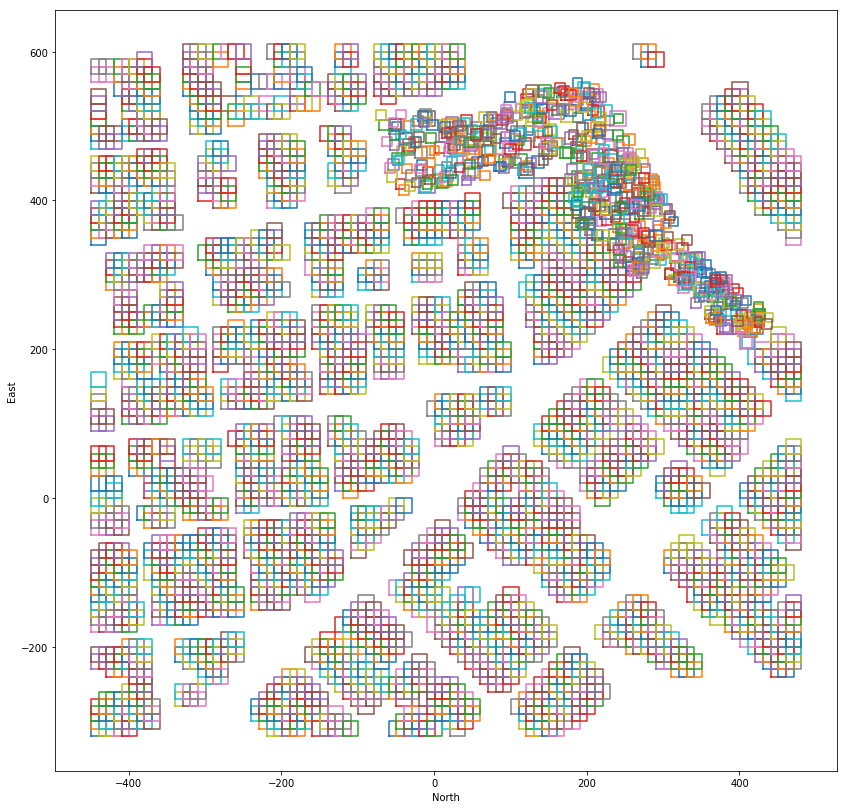

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

# visualize the graph!
fig = plt.figure()
# plt.imshow(grid, cmap='Greys', origin='lower')
# nmin = np.min(data[:, 0])
# emin = np.min(data[:, 1])

# plot the polygons
for poly1 in drone._route_planner._polygons:
#     plt.plot(*poly1._polygon.exterior.xy)
    x, y = poly1._polygon.exterior.xy
    plt.plot(y, x)
    

plt.xlabel('East')
plt.ylabel('North')

plt.show()

In [15]:
drone = MotionPlanning(connection=None, target_altitude=TARGET_ALTITUDE, safety_distance=SAFETY_DISTANCE,
                       graph_num_samples=ROUTE_GRAPH_NUM_SAMPLES, graph_k=ROUTE_GRAPH_K, use_grid=False,
                       prune_path=True, threaded=False)


Creating obstacle tree...
Loading Graph  graph/route_graph_alt50_samp3000_k30_safety5.gpickle
...Done
Global Home (lat/lon/alt):  (-122.39745, 37.79248, 0.0)


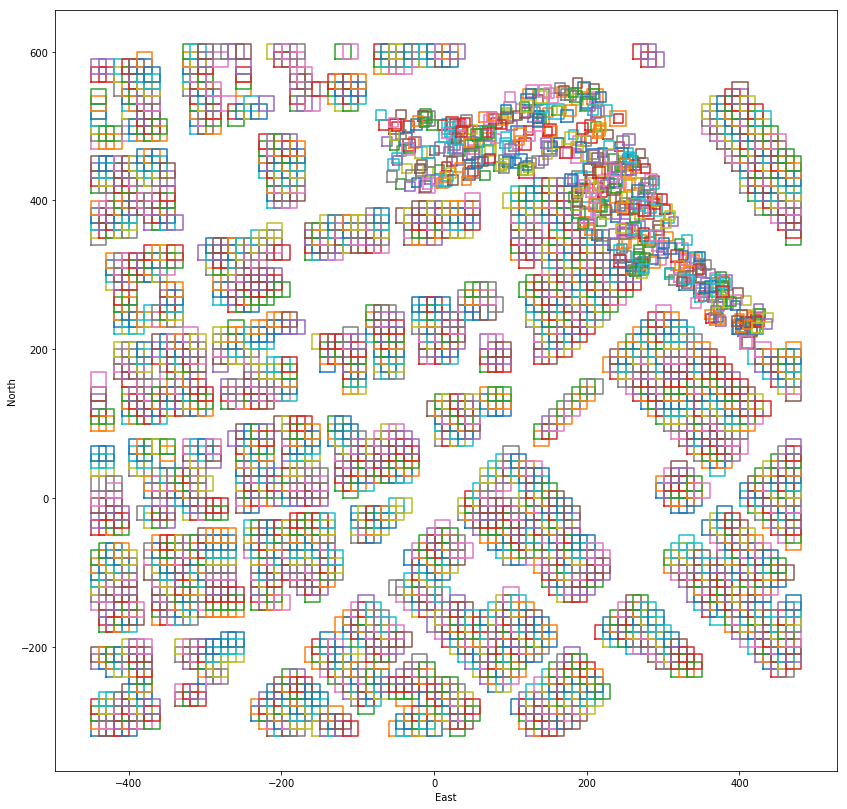

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

# visualize the graph!
fig = plt.figure()
# plt.imshow(grid, cmap='Greys', origin='lower')
# nmin = np.min(data[:, 0])
# emin = np.min(data[:, 1])

# plot the polygons
for poly1 in drone._route_planner._polygons:
    if poly1.height >= 10: # TARGET_ALTITUDE:
#         plt.plot(*poly1._polygon.exterior.xy)
        x, y = poly1._polygon.exterior.xy
        plt.plot(y, x)
    

plt.xlabel('East')
plt.ylabel('North')

plt.show()

Closing connection ...
Closing connection ...


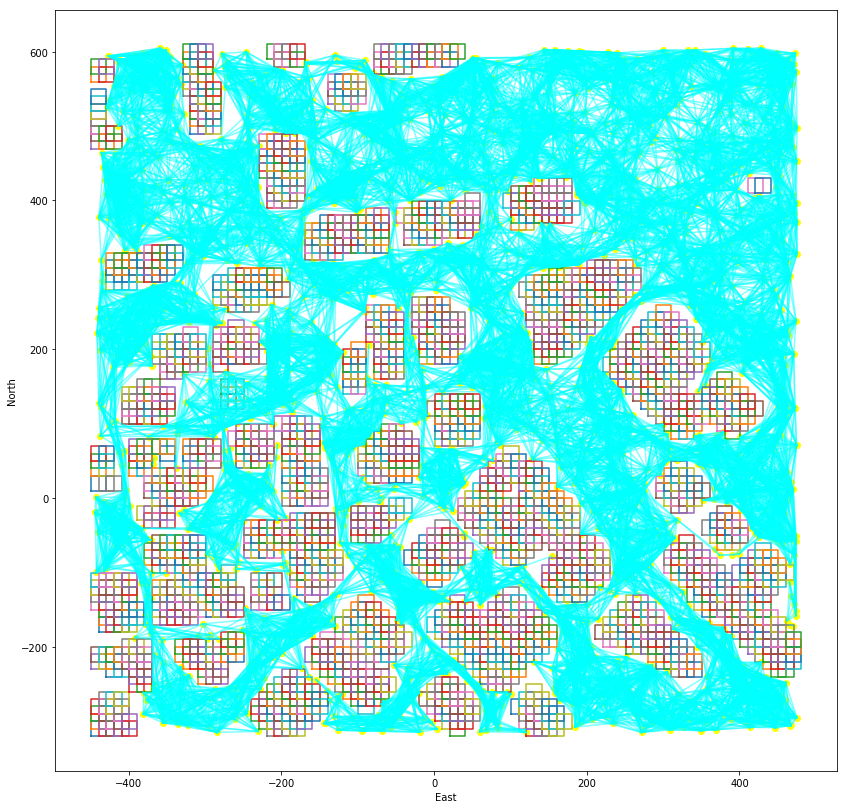

In [16]:
# Final plot!

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

# visualize the graph!
fig = plt.figure()
# plt.imshow(grid, cmap='Greys', origin='lower')
# nmin = np.min(data[:, 0])
# emin = np.min(data[:, 1])

# plot the polygons
for poly1 in drone._route_planner._polygons:
    if poly1.height >= drone._target_altitude:
#         plt.plot(*poly1._polygon.exterior.xy)
        x, y = poly1._polygon.exterior.xy
        plt.plot(y, x)

# # Draw all nodes connected or not in blue
# for n1 in drone._route_planner._sample_nodes:
#    plt.scatter(n1[1], n1[0], c='gray')
    
# Draw connected nodes in red
for n1 in drone._route_planner._route_graph_nodes:
    plt.scatter(n1[1], n1[0], c='yellow')
    
# If you have a graph called "g" these plots should work
# Draw edges
# for (n1, n2) in g.edges:
for (n1, n2) in drone._route_planner._route_graph.edges:    
#    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)
#    plt.plot([n1[0], n2[0]], [n1[1], n2[1]], c='#00FFFF' , alpha=0.5)
    plt.plot([n1[1], n2[1]], [n1[0], n2[0]], c='#00FFFF' , alpha=0.5)

# # start (1.2848236571327902, 19.55647320442438, 0.8624632035562341) 
# # gola (129.81191958841924, -29.972521184900472, 3.9831445502699596)

# start_node_graph = (1.2848236571327902, 19.55647320442438, 0.8624632035562341) 
# stop_node_graph = (129.81191958841924, -29.972521184900472, 3.9831445502699596)
# plt.scatter(start_node_graph[1], start_node_graph[0], c='green')
# plt.scatter(stop_node_graph[1], stop_node_graph[0], c='red')

# # # drone.start_loc, drone.goal_loc
# # plt.scatter(drone.start_loc.location[1], drone.start_loc.location[0], c='green')
# # plt.scatter(drone.goal_loc.location[1], drone.goal_loc.location[0], c='red')

plt.xlabel('East')
plt.ylabel('North')

plt.show()

### Old Incorrect trials

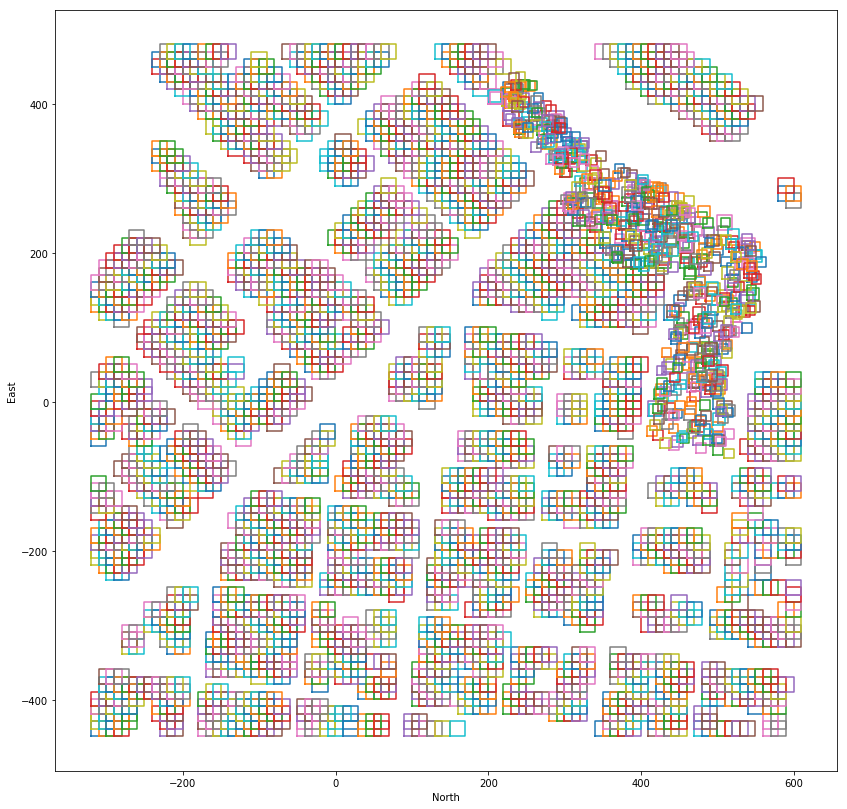

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

# visualize the graph!
fig = plt.figure()
# plt.imshow(grid, cmap='Greys', origin='lower')
# nmin = np.min(data[:, 0])
# emin = np.min(data[:, 1])

# plot the polygons
for poly1 in drone._route_planner._polygons:
    plt.plot(*poly1._polygon.exterior.xy)

plt.xlabel('North')
plt.ylabel('East')

plt.show()

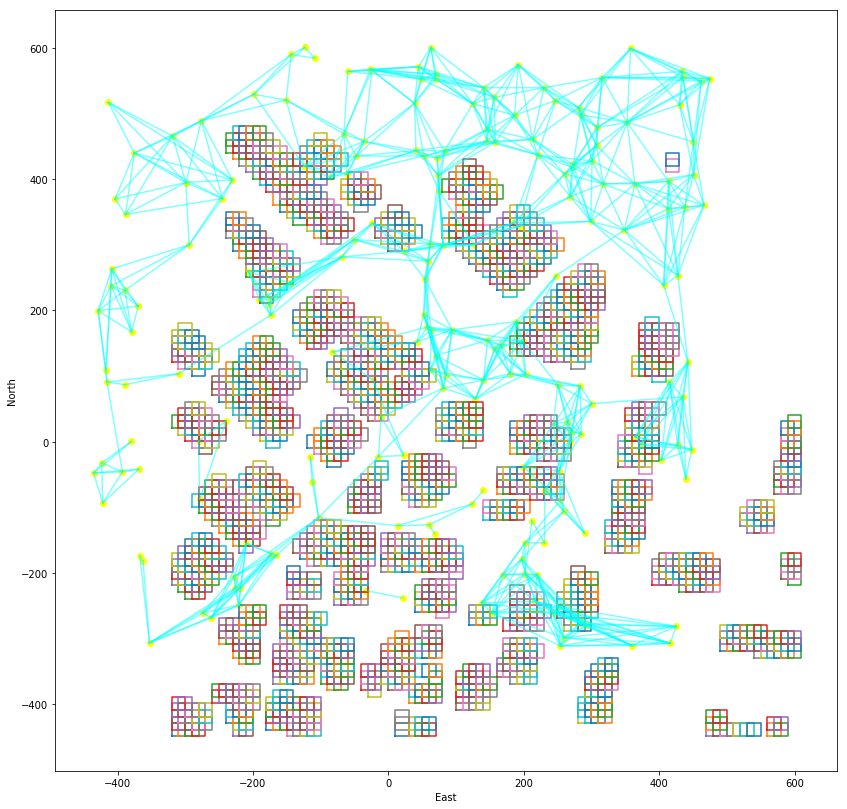

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

# visualize the graph!
fig = plt.figure()
# plt.imshow(grid, cmap='Greys', origin='lower')
# nmin = np.min(data[:, 0])
# emin = np.min(data[:, 1])

# plot the polygons
for poly1 in drone._route_planner._polygons:
    if poly1.height >= TARGET_ALTITUDE:
        plt.plot(*poly1._polygon.exterior.xy)

# # Draw all nodes connected or not in blue
# for n1 in drone._route_planner._sample_nodes:
#    plt.scatter(n1[1], n1[0], c='gray')
    
# Draw connected nodes in red
for n1 in drone._route_planner._route_graph_nodes:
    plt.scatter(n1[1], n1[0], c='yellow')
    
# If you have a graph called "g" these plots should work
# Draw edges
# for (n1, n2) in g.edges:
for (n1, n2) in drone._route_planner._route_graph.edges:    
#    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)
   plt.plot([n1[1], n2[1]], [n1[0], n2[0]], c='#00FFFF' , alpha=0.5)

# # start (1.2848236571327902, 19.55647320442438, 0.8624632035562341) 
# # gola (129.81191958841924, -29.972521184900472, 3.9831445502699596)

# start_node_graph = (1.2848236571327902, 19.55647320442438, 0.8624632035562341) 
# stop_node_graph = (129.81191958841924, -29.972521184900472, 3.9831445502699596)
# plt.scatter(start_node_graph[1], start_node_graph[0], c='green')
# plt.scatter(stop_node_graph[1], stop_node_graph[0], c='red')

# # # drone.start_loc, drone.goal_loc
# # plt.scatter(drone.start_loc.location[1], drone.start_loc.location[0], c='green')
# # plt.scatter(drone.goal_loc.location[1], drone.goal_loc.location[0], c='red')

plt.xlabel('East')
plt.ylabel('North')

plt.show()

### Obstacles TALLER Than TARGET_ALTITUDE

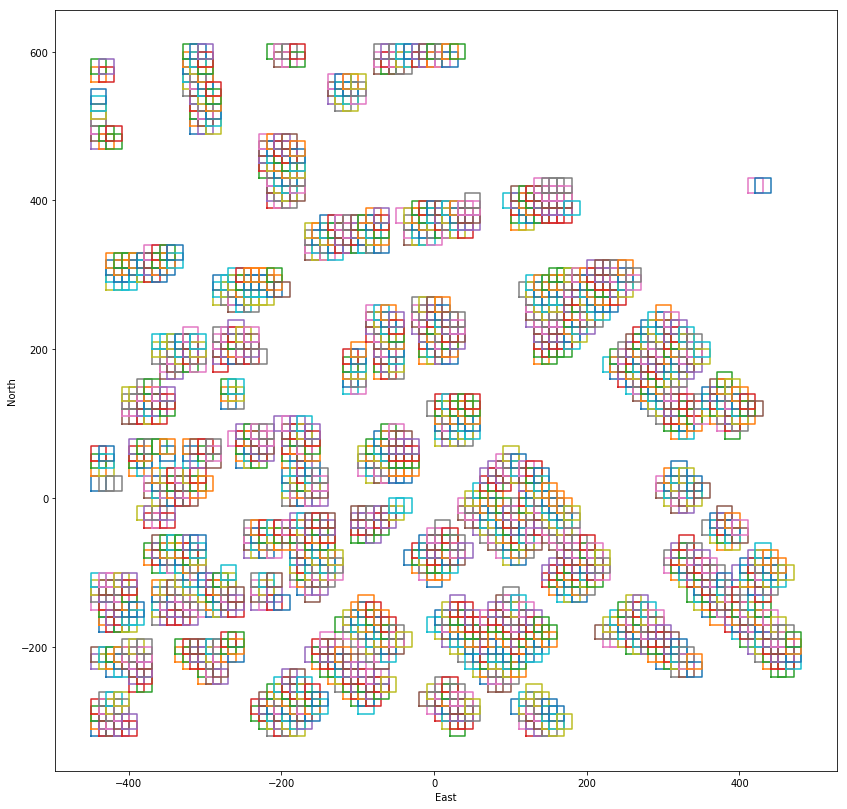

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

# visualize the graph!
fig = plt.figure()
# plt.imshow(grid, cmap='Greys', origin='lower')
# nmin = np.min(data[:, 0])
# emin = np.min(data[:, 1])

# plot the polygons
for poly1 in drone._route_planner._polygons:
    if poly1.height >= TARGET_ALTITUDE:
        plt.plot(*poly1._polygon.exterior.xy)

plt.xlabel('East')
plt.ylabel('North')

plt.show()

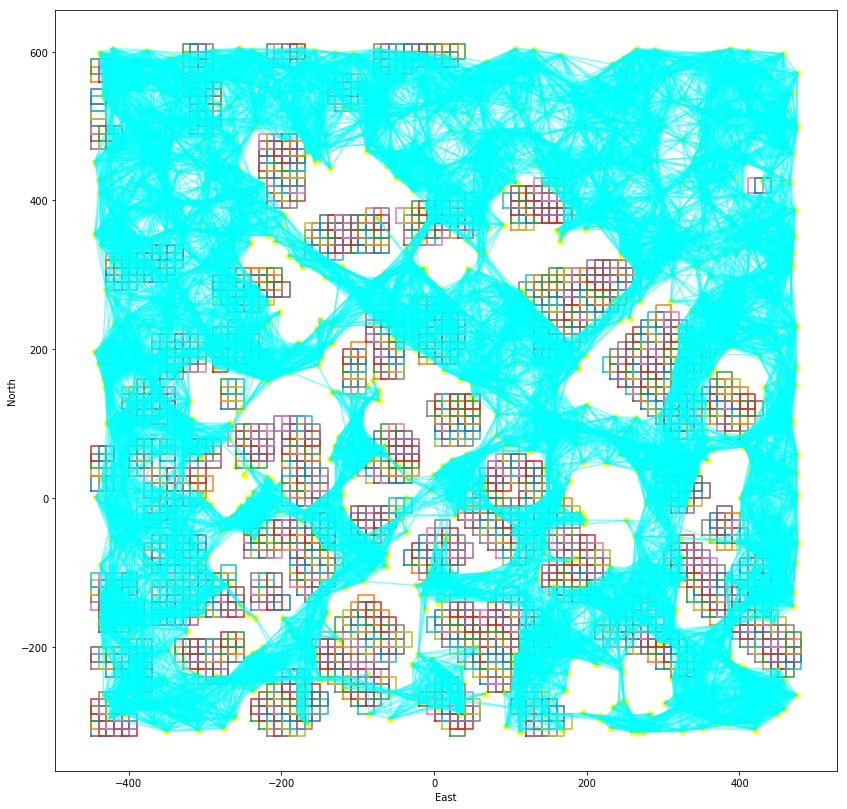

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 14, 14

# visualize the graph!
fig = plt.figure()

# plot the polygons
for poly1 in drone._route_planner._polygons:
    if poly1.height >= TARGET_ALTITUDE:
        plt.plot(*poly1._polygon.exterior.xy)

# Draw connected nodes in red
for n1 in drone._route_planner._route_graph_nodes:
    plt.scatter(n1[1], n1[0], c='yellow')
    
# If you have a graph called "g" these plots should work
# Draw edges
# for (n1, n2) in g.edges:
for (n1, n2) in drone._route_planner._route_graph.edges:    
#    plt.plot([n1[1] - emin, n2[1] - emin], [n1[0] - nmin, n2[0] - nmin], 'black' , alpha=0.5)
   plt.plot([n1[1], n2[1]], [n1[0], n2[0]], c='#00FFFF' , alpha=0.5)

plt.xlabel('East')
plt.ylabel('North')

plt.show()

In [4]:
import pickle

In [7]:
drone._route_planner._graph

In [8]:
import networkx as nx

In [11]:
nx.write_gpickle(drone._route_planner._graph, "graph/graph.gpickle")

In [12]:
g = nx.read_gpickle("graph/graph.gpickle")

In [13]:
g